# Coding Exercise 3

## Question 1: Optimal Consumption with Income Fluctuations

### The model

Consider a household that maximize

$$
\max_{\{c_t\}_{t = 0}^\infty } \mathbb{E} \sum_{t=0}^{\infty} \beta^t u(c_t),
$$
where $ \beta \in (0,1) $ is the discount factor and $ c_t $ is consumption at time $t$  

subject to

<a id='resource_constraint'></a>
$$
a_{t+1} \leq  (1+r_t) a_t  + w_t h_t - c_t,
\quad c_t \geq 0,
\quad a_t \geq 0
\quad t = 0, 1, \ldots \tag{1}
$$

where

- $ \beta \in (0,1) $ is the discount factor.
- $ a_t $ is asset holdings at the beginning of time $ t $ with a borrowing constraint: $ a_t \geq 0 $ $\forall t$. 
- $ c_t $ is consumption, and $h_t$ is hours worked.
- $ w_t $ is wages and $ r_t $ is the interest rate.

Each period, the household is endowed with one unit of time. Due to the specification of utility function the household inelastically supply the whole hour as labor, i.e., $h_t=1$ for all $t$.

The interest rate ($r_t$) and wages ($w_t$) are given, respectively, $r_t = r(Z_t)$ and $w_t = w(Z_t)$, where $Z_t$ follows a finite state Markov process with a state space $\mathcal{Z}=\{0,1\}$ and a Markov matrix as below:

$$
P = \left[\begin{matrix}
    0.9 & 0.1 \\
    0.1 & 0.9
    \end{matrix}\right]
$$

For simplicity of computation, We assume that $r(0)=0.025$, $r(1)=0.035$, $w(0)=0.8$ and $w(1)=1.2$.

Notice that the resource constraint for the household in [(1)](#resource_constraint) is different from the one that we considered in the lecture. This represents the timing of events within a period as follows:

1. In period $ t $, the household starts the period with asset holds $a_t$ which transmitted from the previous period.
1. At the beginning of period $ t $, the household observes the realizations of the interest rate and wages, $r_t$ and $w_t$ which are determined accoding to the Markov processes.
1. The household receives the gross capital income $(1+r_t) a_t$ and labor income $w_t h_t$. 
1. The household chooses her consumption $c_t$.
1. Time shifts to $ t+1 $ and the process repeats.

It is clear that the state for the household is a pair of $ (a,z) \in \mathsf S := \mathbb R_+ \times \mathcal{Z} $. 

### The Euler Equation

In period $t$, the total resources for the houshold is $(1+r_{t})a_t + w_t$ is disposed of into consumption $c_t$ and the next period asset $a_{t+1}$. Due to the borrowing constraint, $a_{t+1} \ge 0$. Taking this into consideration, the optimal condition for the consumption choices can be summarized by the following Euler equation:

<a id='euler_equation'></a>
$$
u'(c_t) = \max \left\{\beta\, \mathbb{E}_t \left[ (1+r_{t+1}) u'(c_{t+1}) \right], \;  u'\left((1+r_{t})a_t+w_t\right)
\right\} \tag{2}
$$

There exists an *optimal consumption function* $ \sigma^* \colon \mathsf S \to \mathbb R_+ $ that solves [(2)](#euler_equation) for all $ (a,z) \in \mathsf{S} $, i.e., 

<a id='EE'></a>
$$
\begin{aligned}
(u' \circ \sigma) (a, z) &= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) (\hat{a},\hat{z}) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\\
&= \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-\sigma(a,z),\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\end{aligned}
\tag{3}
$$


Let's solve for the optimal policy for consumption through the **time iteration** method.

### Q.1-0: Import necessary packages.

First, import the following external libraries:

1. `MarkoovChain` from `quantecon` to handle finite state Markov process
1. `brentq` from `quantecon` to solve for the optimal policy at each state. 
1. `interp` from `interpolation` to evaluate the optimal policy an off-grid point.
1. `numba` package to jit-compile class and functions.
1. `pyplot` from `matplotlib` to present results graphically.

In [106]:
# your code here
import numpy as np
from quantecon.optimize import brent_max, brentq
from quantecon import MarkovChain
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

### Q.1-1: Define the class for the model economy

Write a class **IFP** that specifies the following.

- discount factor: $\beta = 0.965$
- CRRA parameter: $\gamma=2$
- interest rate values: as specified above
- wage values: as specified above
- Markov matrix: P as specified above
- marginal uility function: $c^{-\gamma}$
- asset grid vector: $a \in [0, 20]$ with grid_size = 200
- collect the model parameters and declare their types in **ifp_data**
- jit-compile the class with `@jitclass`

Assume that the condition for convergence, $\beta E[1+r(\hat{z})] < 1$ is satisfied with the above values for `r` and `beta`.

In [107]:
# your code here
ifp_data = [
    ('β', float64),              # Discount factor
    ('γ', float64),              # Preference parameter
    ('P', float64[:, :]),        # Markov matrix for binary Z_t
    ('r', float64[:]),           # Interest is r_t = r[Z_t]
    ('w', float64[:]),           # Wage is w_t=w[Z_t]
    ('asset_grid', float64[:])   # Grid (array)
]

@jitclass(ifp_data)
class IFP:

    def __init__(self,
                 β=0.965,
                 γ=2.0,
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 r=np.array((0.025, 0.035)),
                 w=np.array((0.8, 1.2)),
                 grid_max=20,
                 grid_size=200):

        self.β, self.γ = β, γ
        self.P, self.r, self.w = P, r, w
        self.asset_grid = np.linspace(0, grid_max, grid_size)

        # Recall that we need β*E[1+r(z_hat)] < 1 for convergence.
        #assert self.β*(1+self.r) < 1, "Stability condition violated."

    def u_prime(self, c):
        return c**(-self.γ)
    
    def euler_diff(self, c, a, z, σ_vals):
        """
        The difference between the left- and right-hand side
        of the Euler Equation, given current policy σ.

            * c is the consumption choice
            * (a, z) is the state, with z in {0, 1}
            * σ_vals is a policy represented as a matrix.
            * ifp is an instance of IFP

        """

        # Simplify names
        P, r, w, β, γ  = self.P, self.r, self.w, self.β, self.γ
        asset_grid, u_prime = self.asset_grid, self.u_prime
        n = len(P)

        # Convert policy into a function by linear interpolation
        σ = lambda a,z: interp(asset_grid, σ_vals[:, z], a)

        # Calculate the expectation conditional on current z
        expect = 0.0
        for z_hat in range(n):
            expect += (1+r[z_hat])*u_prime(σ((1+r[z])*a + w[z]-σ(a,z), z_hat)) * P[z, z_hat]

        return u_prime(c) - max(β * expect, u_prime((1+r[z])*a + w[z]))

### Q.1-2: Define the Coleman Operator

Write a function that defines the Coleman operator $K$ that updates the optimal policy function $\sigma$ by solving the (nonlinear) Equler equation for $c$ for all $(a,z) \in \mathsf{S}$. 

<a id='EE_sigma'></a>
$$
u'(c) = \max \left\{\beta\, \mathbb{E}_z \left[ \left(1+r(\hat{z})\right) (u' \circ \sigma) \left((1+r(z))a+w[z]-c,\hat{z} \right) \right], \;  u'\left((1+r(z))a+w[z]\right) \right\}
\tag{4}
$$

- function head: **K($\sigma$, ifp)**
- $\sigma$ is a matrix of which elements are the optimal consumption $c^*$ for state $(a,z) \in \mathsf S$ in the current iteration.
- `ifp` is the instance of the class IFP to be initiated later.
- solve the nonlinear euqation for $c^*$ for each pair of $(a,z)$ using `brentq` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/root_finding.html) to find the usage of `brentq`.
- update the policy value function $\sigma_{new}$.
- jit-compile the function with @njit

In [108]:
# your code here
@njit
def K(σ, ifp):
    """
    The operator K.

    """
    σ_new = np.empty_like(σ)
    for i, a in enumerate(ifp.asset_grid):
        for z in (0, 1):
            result = brentq(ifp.euler_diff, 1e-8, 1+ifp.r[z]*a+ifp.w[z], args=(a, z, σ))
            σ_new[i, z] = result.root

    return σ_new

### Q.1-3: Implement the Time Iteration


Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_(ifp_in, $\sigma$, tol=1e-4, max_iter=1000, print_skip=10)`
- the arguements are analogous to those in the lecture.
- while iterating, the function should show the progress every 10 iteration.
- the function returns the converged policy function.

In [109]:
# your code here
def solve_model(ifp_in, σ, tol=1e-4, max_iter=1000, verbose=True, print_skip=10):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, ifp_in)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

### Q.1-4: Run the Time Iteration

- create an instance of the class IFP `ifp` with the default parameter values defined in the class.
- initialize the optimal consumption matrix $\sigma$ with the asset grid vector for all $z$.
- run `solve_model` and save the converged comsumption policy in a matrix *c_opt*.
- compute the optimal asset holdings in the next period, $\hat{a}$, using *c_opt* and the resource constraint and save them in a matrix *ap_opt*.
- plot *c_opt* for each $z$ against assets ($a$).
- plot *ap_opt* for each $z$ against assets ($a$).


In [110]:
# your code here
ifp = IFP()
# Set up initial consumption policy of consuming all assets at all z
z_size = len(ifp.P)
a_grid = ifp.asset_grid
a_size = len(a_grid)
σ_init = np.repeat(a_grid.reshape(a_size, 1), z_size, axis=1)

%time c_opt = solve_model(ifp, σ_init)

Error at iteration 10 is 0.0115593909463656.
Error at iteration 20 is 0.004340615000479664.
Error at iteration 30 is 0.0028226202708312442.
Error at iteration 40 is 0.002365011378242965.
Error at iteration 50 is 0.00218131624111928.
Error at iteration 60 is 0.001903075412025279.
Error at iteration 70 is 0.0015883659914701642.
Error at iteration 80 is 0.001274172474516.
Error at iteration 90 is 0.000980547859816605.
Error at iteration 100 is 0.0007261699752900697.
Error at iteration 110 is 0.0005199201755838878.
Error at iteration 120 is 0.0003619267410412963.
Error at iteration 130 is 0.0002461604031349651.
Error at iteration 140 is 0.00016428703142556955.
Error at iteration 150 is 0.00010798136240564027.

Converged in 152 iterations.
CPU times: total: 875 ms
Wall time: 928 ms


In [111]:
ap_opt = np.array([(1+ifp.r[0])*ifp.asset_grid + ifp.w[0] - c_opt[:, 0], (1+ifp.r[1])*ifp.asset_grid + ifp.w[1] - c_opt[:, 1]])
print(ap_opt)

[[ 0.          0.05901698  0.13567648  0.2187763   0.30534528  0.39427064
   0.48479614  0.57646414  0.66901222  0.76226325  0.85609273  0.9504081
   1.04513865  1.14022869  1.23563354  1.33131667  1.42724777  1.52340138
   1.61975586  1.71629268  1.81299579  1.9098512   2.00685104  2.10397962
   2.20123049  2.29859167  2.39605761  2.49361936  2.5912718   2.68900828
   2.78682407  2.88471411  2.98267417  3.08070021  3.17878857  3.2769359
   3.37513906  3.47339519  3.57170161  3.67005585  3.7684556   3.86689872
   3.9653832   4.06390716  4.16246885  4.26106661  4.35969891  4.45836428
   4.55706136  4.65578884  4.75454552  4.85333024  4.9521419   5.05097948
   5.149842    5.24872853  5.34763818  5.44657013  5.54552357  5.64449775
   5.74349193  5.84250545  5.94153763  6.04058785  6.13965552  6.23874005
   6.33784091  6.43695757  6.53608952  6.6352363   6.73439742  6.83357255
   6.93276125  7.03196303  7.13117756  7.23040448  7.32964333  7.42889383
   7.52815565  7.6274284   7.72671182  7

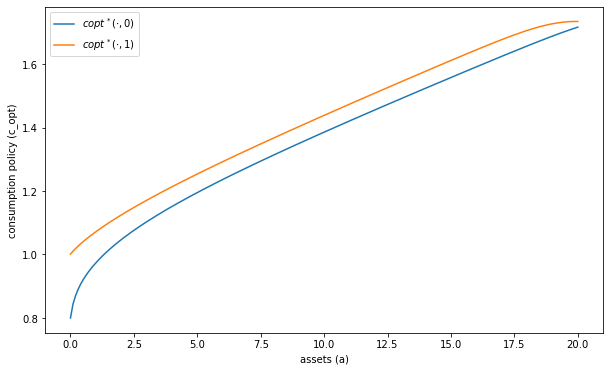

In [112]:
fig, ax = plt.subplots()
for z in range(z_size):
    label = rf'$c opt^*(\cdot, {z})$'
    ax.plot(a_grid, c_opt[:, z], label=label)
ax.set(xlabel='assets (a)', ylabel='consumption policy (c_opt)')
ax.legend()
plt.show()

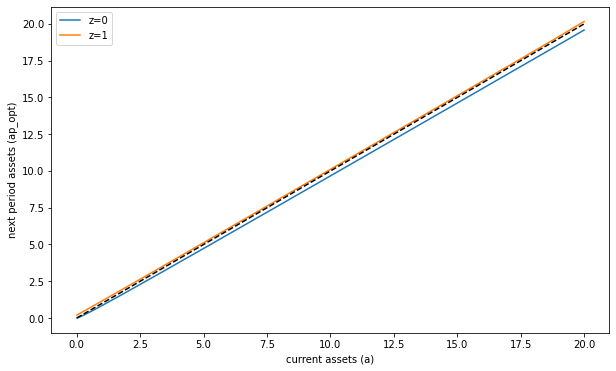

In [113]:
fig, ax = plt.subplots()
for z, lb in zip((0, 1), ('z=0', 'z=1')):
    ax.plot(a_grid, (1+ifp.r[z])*ifp.asset_grid + ifp.w[z] - c_opt[:, z], label=lb)

ax.plot(a_grid, a_grid, 'k--')
ax.set(xlabel='current assets (a)', ylabel='next period assets (ap_opt)')

ax.legend()
plt.show()

### Q.1-5: Simulate the time-series of asset holdings

Suppose that the household is endowed with $a_0$ at the very first period of her life. Each period, she chooses consumption and the next period assets according to the optimal policy function computed above. Write a function that simulates the asset holdings and consumption of the household over 500,000 periods.

- function head: Simulate_Time_Series(ifp, T, seed=1234)
    - `ifp`: instance of the class IFP
    - `c_opt`: optimal consumption function computed above
    - `T`: length of time-series, set to 500,000
    - `seed`: seed for random number generator, set to 1234
- need to interpolate policy functions
- use `MarkovChain` to generate a series of random numbers from a Markov process with Markov matrix P 
- compute and plot the time-series $\{a_t, c_t\}$ for $t=0, 1, \cdots T$.


In [114]:
# your code here
def Simulate_Time_Series(ifp, T=50_000, seed=1234):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

    ifp is an instance of IFP
    """
    P, r, w = ifp.P, ifp.r, ifp.w  # Simplify names

    # Solve for the optimal policy
    σ = lambda a, z: interp(ifp.asset_grid, c_opt[:, z], a)

    # Simulate the exogeneous state process
    mc = MarkovChain(P)
    z_seq = mc.simulate(T, random_state=seed)

    # Simulate the asset path
    a = np.zeros(T+1)
    c = np.zeros(T+1)
    for t in range(T):
        z = z_seq[t]
        a[t+1] = (1+r[z])*a[t] + w[z] - σ(a[t], z)
        c[t] = σ(a[t], z)
        
    return a,c

### Q.1-6: Plot the time-series of assets and consumption

- Generate time-series for asset and consumption.
- Plot histograms of assets and consumption assuming that the generated time-series represent the cross-sectional distributions of assets and consumption.
- Plot the Lorenz curve and compute the Gini coefficients for assets and consumption.


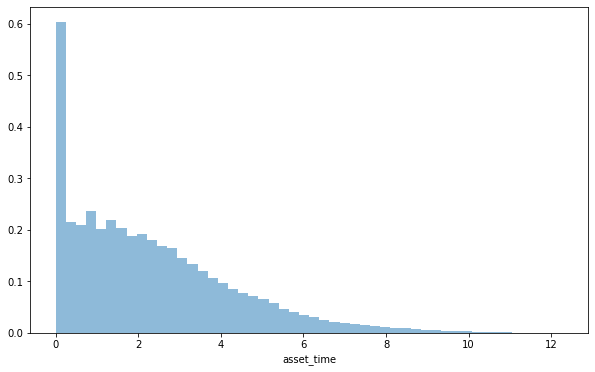

In [115]:
# your code here
ac = Simulate_Time_Series(ifp)
asset_time = ac[0]
consumption_time = ac[1]

fig, ax = plt.subplots()
ax.hist(asset_time, bins=50, alpha=0.5, density=True)
ax.set(xlabel='asset_time')
plt.show()

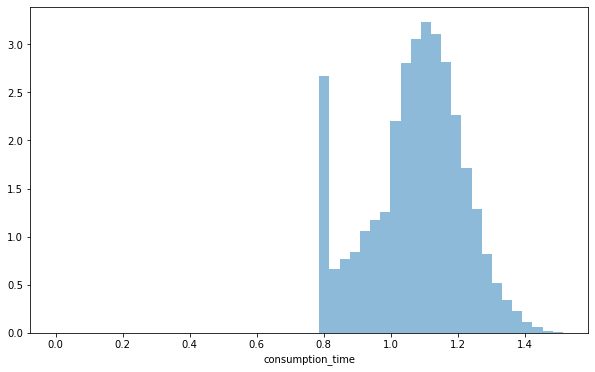

In [116]:
fig, ax = plt.subplots()
ax.hist(consumption_time, bins=50, alpha=0.5, density=True)
ax.set(xlabel='consumption_time')
plt.show()

In [117]:
import quantecon as qe
from numba import njit, float64, prange
from numba.experimental import jitclass

In [118]:
fw, lw = qe.lorenz_curve(asset_time)
gini_fw = qe.gini_coefficient(asset_time)

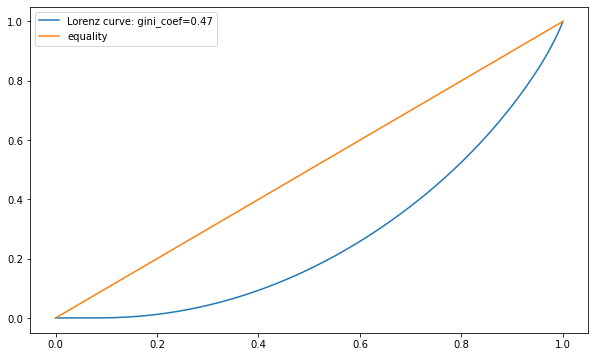

In [119]:
fig, ax = plt.subplots()
ax.plot(fw, lw, label=f'Lorenz curve: gini_coef={gini_fw:.2}')
ax.plot(fw, fw, label='equality')
ax.legend()

plt.show()

## Question 2: Lake Model of Labor Markets

### The Model

The economy is inhabited by a very large number of ex-ante identical workers. Let's normalize the total number of workers (population) to unity. The workers live forever, spending their lives moving across three labor market states: employment ($E$), unemployment ($U$) and out of labor force ($O$). There are six possible transitions across three states over the course of two consecutive periods.

1. An employed worker in period $t$ becomes unemployed in the next period with probability $\alpha$.
1. An employed worker in period $t$ goes out of labor force in the next period with probability $\delta$.
1. An unemployed worker in period $t$ become employed in the next period with probability $\lambda$.
1. An unemployed worker in period $t$ goes out of labor firce in the next period with probability $\kappa$.
1. A worker out of labor force in period $t$ becomes employed in the next period with probability $\eta$.
1. A worker out of labor force in period $t$ becomes unemployed in the next period with probability $\chi$.


### Laws of Motion for Stock Variables

Labor market stock variables evolve over time according to the following laws of motion. 

1. Employment:
$$
E_{t+1} = (1-\alpha-\delta) E_t + \lambda U_t + \eta O_t
$$

1. Unemployment:
$$
U_{t+1} = \alpha E_t + (1-\lambda-\kappa) U_t + \chi O_t  
$$

1. Out of Labor Force:
$$
O_{t+1} = \delta E_t + \kappa U_t + (1-\eta-\chi) O_t
$$


Let $ X := \left(\begin{matrix} E & U & O \end{matrix}\right) $. Then the law of motion for $ X $ is $X_{t+1} = X_t P$, where 

$$
P = \left[\begin{matrix}
     1-\alpha-\delta & \alpha & \delta \\
     \lambda & 1-\lambda-\kappa & \kappa \\
     \eta & \chi & 1-\eta-\chi \\
    \end{matrix}\right]
$$


### Q.2-1: Define the class for the lake model of labor market

Write a class **Lake** that specifies the following. In the class definition, make the Markov matrix to immediately reflect changes in individual transition probabilities without re-creating the instance of the class. For this, Use descriptors and decorators such as `@property` as we did in the lecture.

- Transition probabilities
    - from E to U: $\alpha = 0.0147$
    - from E to O: $\delta = 0.0313$
    - from U to E: $\lambda = 0.2774$
    - from U to O: $\kappa = 0.2280$
    - from O to E: $\eta = 0.0466$
    - from O to U: $\chi = 0.0245$
- function `__init__`: sets default values for transition probabilities and generate a Markov matrix `P` by calling `construct_P`
- function `construct_P`: construct a Markov matrix `_P`
- function `construct_mc`: construct a Markov Chain object `_mc` with `P`
- using @property and @x.setter decorators, make inidividual transition probabilities and the Markov matrix to be changed.
- function `steady_state`: computes the steady state of the labor market
- function `simulate_stock_path`: simulate a time-series of labor market stock variables


In [120]:
# your code here
class Lake:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    """
    def __init__(self,α=0.0147,δ=0.0313,λ=0.2774,κ=0.2280,η=0.0466,χ=0.0245):
        self._α, self._δ, self._λ, self._κ, self._η, self._χ= α,δ,λ,κ, η, χ
        
        self.compute_derived_values()
        
    def compute_derived_values(self):
        # Unpack names to simplify expression
        α, δ, λ, κ, η, χ= self._α, self._δ, self._λ, self._κ, self._η, self._χ

        self._P = np.array([[1-α-δ, α, δ],
                            [λ, 1-λ-κ, κ],
                            [η, χ, 1-η-χ]])
        
        self._mc = MarkovChain(self._P)

    @property
    def P(self):
        return self._P
    
    @property
    def mc(self):
        return self._mc
    
    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()
    
    @property
    def δ(self):
        return self._δ

    @δ.setter
    def δ(self, new_value):
        self._δ = new_value
        self.compute_derived_values()
    
    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._λ = new_value
        self.compute_derived_values()
        
    @property
    def κ(self):
        return self._κ

    @κ.setter
    def κ(self, new_value):
        self._κ = new_value
        self.compute_derived_values()
        
    @property
    def η(self):
        return self._η

    @η.setter
    def η(self, new_value):
        self._η = new_value
        self.compute_derived_values()
        
    @property
    def χ(self):
        return self._χ

    @χ.setter
    def χ(self, new_value):
        self._χ = new_value
        self.compute_derived_values()

    def steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat P x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = (1/3) * np.ones(3)
        error = tol + 1
        while error > tol:
            new_x = self.P @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment and out of labor force stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0, O0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment and out of labor force stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.P @ X

### Q.2-2: Compute the stationary distribution

We have learned from the lecture 11 (Finite Markov Chain) that if the Markov matrix is both irreducible and aperiodic, then there exist a unique stationary distribution of states. 

- create an instance of the class, `LM`.

In [121]:
# your code here
LM = Lake()

- check if the labor market is irreducible using a method in `quantecon.MarkovChain`

In [122]:
# your code here
import quantecon as qe
α=0.0147
δ=0.0313
λ=0.2774
κ=0.2280
η=0.0466
χ=0.0245
P = np.array([[1-α-δ, α, δ], [λ, 1-λ-κ, κ], [η, χ, 1-η-χ]])

IR = qe.MarkovChain(P, ('E','U','O'))
IR.is_irreducible

True

- check if the labor market is aperiodic using a method in `quantecon.MarkovChain`

In [123]:
# your code here
IR.is_aperiodic

True

- compute the stationary distribution of labor market states using the function `stationary_distgribution` included in `quantecon.MarkovChain`.

In [124]:
# your code here
IR.stationary_distributions

array([[0.59122535, 0.03530098, 0.37347367]])

- compute the stationary distribution of labor market states using the function `steady_state` included in the class `Lake`.

In [125]:
# your code here
x0 = LM.steady_state()
print(f"Initial Steady State: {x0}")

Initial Steady State: [0.33333333 0.33333333 0.33333333]


### Q.2-3: Simulate Labor Market Stocks

Let's simulate labor market stock variables for 50 periods, `T=50`, according to the system that we constructed with the class `Lake`.

- set initial values for labor market stocks: `X_0`
- compute the steady state of the labor market: `xbar`
- simulate labor market stocks with the function `simulate_stock_path`.
- plot the simulated labor market stock variables with their steady states.


In [126]:
# your code here
T=50
#임의의 E0, U0, O0의 값을 설정
E0=0.5
U0=0.2
O0=0.3
X_0 = (E0, U0, O0)
xbar = LM.steady_state()
x_path = np.vstack(tuple(LM.simulate_stock_path(X_0, T)))

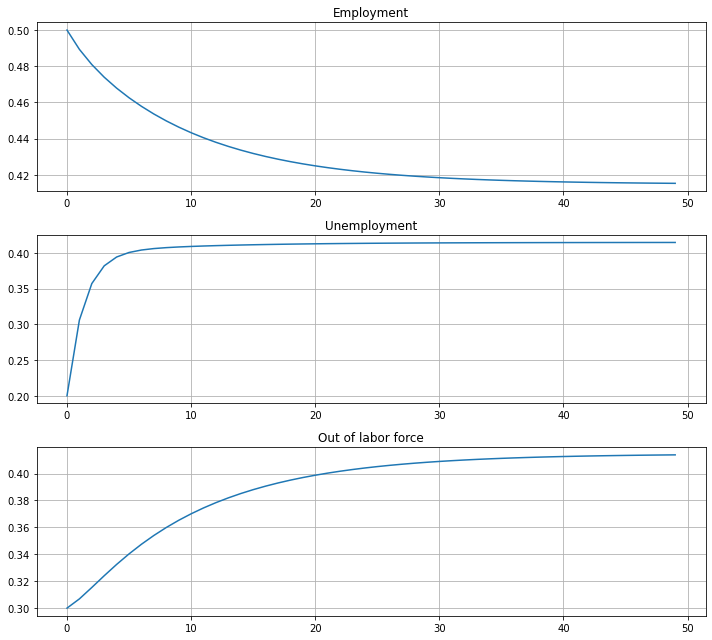

In [127]:
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(x_path[:, 0])
axes[0].set_title('Employment')

axes[1].plot(x_path[:, 1])
axes[1].set_title('Unemployment')

axes[2].plot(x_path[:,2])
axes[2].set_title('Out of labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-4: An Invididual Worker's Turnover across Labor Market States

Let's simulate an individual worker's turnovers (transitions) across the labor market stock variables for $T=50,000$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time.

- simuate individual worker's state using Markov chain: `s_path`
- from `s_path`, construct a time series `e_path` that consists of 0 or 1 where 1 represents employment
- from `s_path`, construct a time series `u_path` that consists of 0 or 1 where 1 represents unemployment
- from `s_path`, construct a time series `o_path` that consists of 0 or 1 where 1 represents out of labor force
- using `e_path` generate a time series, `s_bar_e` of percentage of time employed until time $t$
- using `u_path` generate a time series, `s_bar_u` of percentage of time unemployed until time $t$
- using `o_path` generate a time series, `s_bar_o` of percentage of time out of labor force until time $t$
- plot `s_bar_e`, `s_bar_u`, `s_bar_o`

In [128]:
# your code here
np.random.seed(12)
T=50000
mc = LM.mc
s_path = mc.simulate(T, init=1)
print(s_path)

[1 0 0 ... 2 2 2]


In [129]:
e_path = s_path.copy()
for index, value in enumerate(e_path):
    if value == 1:
        e_path[index] = 0
    elif value == 0:
        e_path[index] = 1
    else:
        e_path[index] = 0

print(e_path)

[0 1 1 ... 0 0 0]


In [130]:
u_path = s_path.copy()
for index, value in enumerate(u_path):
    if value == 1:
        u_path[index] = 1
    elif value == 0:
        u_path[index] = 0
    else:
        u_path[index] = 0

print(u_path)

[1 0 0 ... 0 0 0]


In [131]:
o_path = s_path.copy()
for index, value in enumerate(o_path):
    if value == 1:
        o_path[index] = 0
    elif value == 0:
        o_path[index] = 0
    else:
        o_path[index] = 1

print(o_path)

[0 0 0 ... 1 1 1]


In [132]:
s_bar_e = e_path.cumsum() / range(1, T+1)
s_bar_u = u_path.cumsum() / range(1, T+1)
s_bar_o = o_path.cumsum() / range(1, T+1)

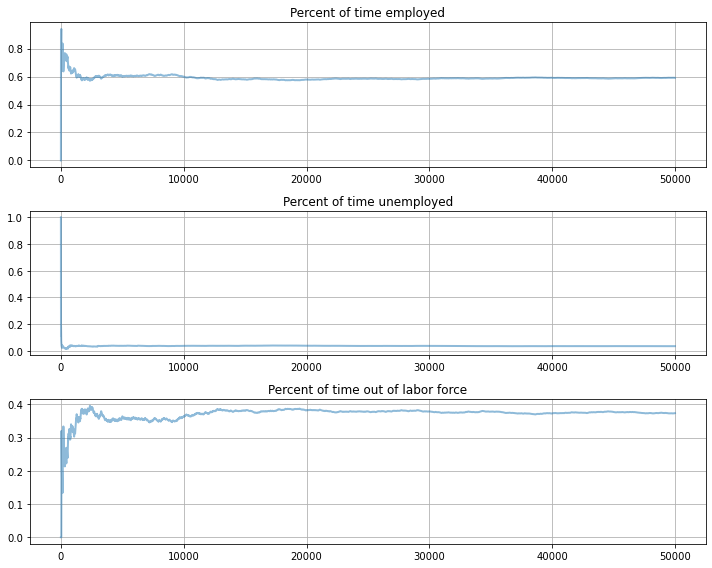

In [133]:
to_plot = [s_bar_e, s_bar_u, s_bar_o]
titles = ['Percent of time employed', 'Percent of time unemployed', 'Percent of time out of labor force']

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()

### Q.2-5: Effects of Changes in Transition Probabilities on Labor Market Stocks

Let's simulate the labor market stock variables for $T=50$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. In other words, exit probabilities from employment to either unemployment or out of labor force will increase. Write codes for simulating and plotting the labor market stocks as you did in Q.2-3.


In [134]:
# your code here
T1=19
x_path1 = np.vstack(tuple(LM.simulate_stock_path(X_0, T1)))

In [135]:
α_hat = 0.03
δ_hat = 0.05

LM.α = α_hat
LM.δ = δ_hat
T=50
T_hat=20

x_path2 = np.vstack(tuple(LM.simulate_stock_path(x_path1[-1, :3], T-T_hat+1)))

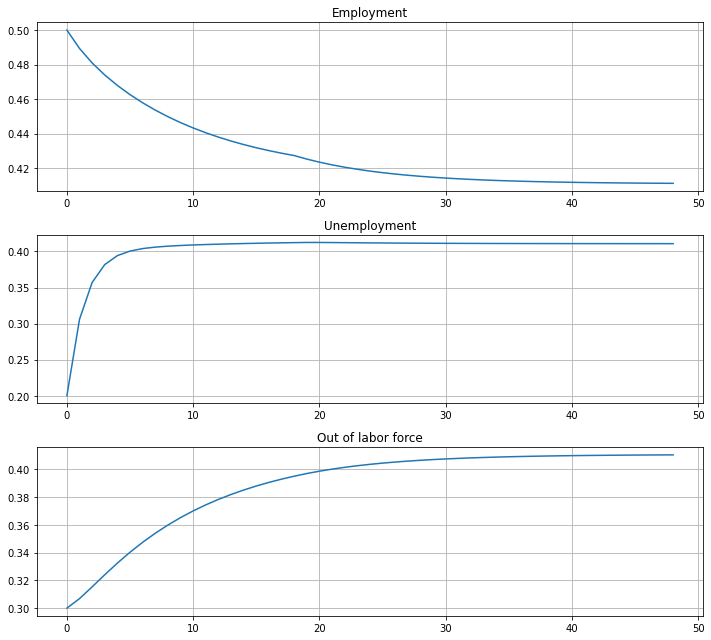

In [136]:
# note [1:] to avoid doubling period 20
x_path = np.vstack([x_path1, x_path2[1:]])

fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(x_path[:, 0])
axes[0].set_title('Employment')

axes[1].plot(x_path[:, 1])
axes[1].set_title('Unemployment')

axes[2].plot(x_path[:, 2])
axes[2].set_title('Out of labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

### Q.2-6: Effects of Changes in Transition Probabilities on Individual Worker's Turnovers in the Labor Market

Let's simulate an individual worker's turnovers in the labor market stock variables for $T=50,000$ again. Now, suppose that the following changes in transition probabilites will take place in period $\hat{T} = 20,000$: $\hat{\alpha} = 0.03$ and $\hat{\delta} = 0.05$. Write codes for simulating and plotting the individual worker's turnovers across labor market states over time as you did in Q.2-4.


In [137]:
# your code here
T=50000
T_hat = 20000
e_path1 = e_path[:T_hat-1]
u_path1 = u_path[:T_hat-1]
o_path1 = o_path[:T_hat-1]
s_path1 = s_path[:T_hat-1]

In [138]:
np.random.seed(12)
T=50000
α_hat = 0.03
δ_hat = 0.05

LM.α = α_hat
LM.δ = δ_hat
mc = LM.mc
s_path2 = mc.simulate(T-T_hat+1, init=1)

In [139]:
e_path2 = s_path2.copy()
for index, value in enumerate(e_path2):
    if value == 1:
        e_path2[index] = 0
    elif value == 0:
        e_path2[index] = 1
    else:
        e_path2[index] = 0

In [140]:
u_path2 = s_path2.copy()
for index, value in enumerate(u_path2):
    if value == 1:
        u_path2[index] = 1
    elif value == 0:
        u_path2[index] = 0
    else:
        u_path2[index] = 0

In [141]:
o_path2 = s_path2.copy()
for index, value in enumerate(o_path2):
    if value == 1:
        o_path2[index] = 0
    elif value == 0:
        o_path2[index] = 0
    else:
        o_path2[index] = 1

In [142]:
e_path_hat = np.append(e_path1, e_path2)
u_path_hat = np.append(u_path1, u_path2)
o_path_hat = np.append(o_path1, o_path2)

In [143]:
s_bar_e1 = e_path_hat.cumsum() / range(1, T+1)
s_bar_u1 = u_path_hat.cumsum() / range(1, T+1)
s_bar_o1 = o_path_hat.cumsum() / range(1, T+1)

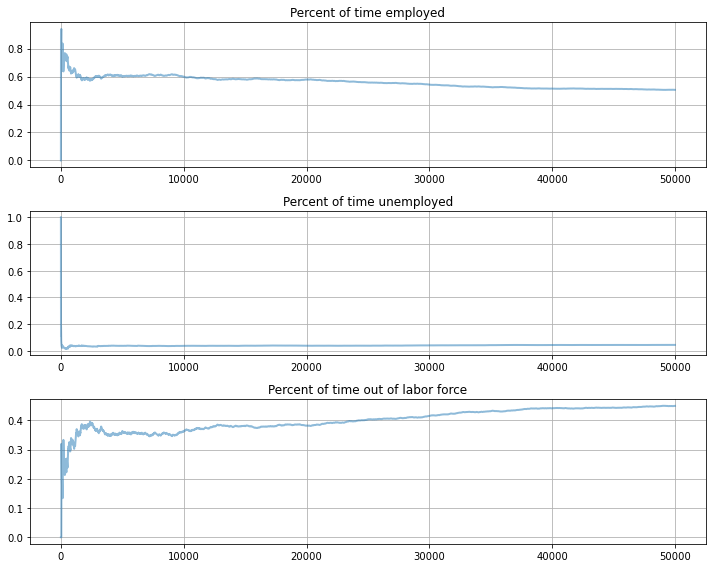

In [144]:
to_plot = [s_bar_e1, s_bar_u1, s_bar_o1]
titles = ['Percent of time employed', 'Percent of time unemployed', 'Percent of time out of labor force']

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()